In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import plotnine as pn
import seaborn as sns
import gseapy

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")


-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
OpenSSL             20.0.1
PIL                 8.1.1
adjustText          NA
anndata             0.7.5
anyio               NA
appdirs             1.4.4
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bioservices         1.7.11
brotli              NA
bs4                 4.9.3
bson                NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
colorlog            NA
cryptography        3.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
descartes           NA
docutils            0.16
easydev             0.11.0
fasteners           NA
future_fstrings     NA
google              NA
gridfs              NA
gseapy              0.10.4
h5py             

In [3]:
ileum_infection_sc = sc.read_h5ad(filename="./../pyobjs_github/ileum_infection_sc.h5ad")

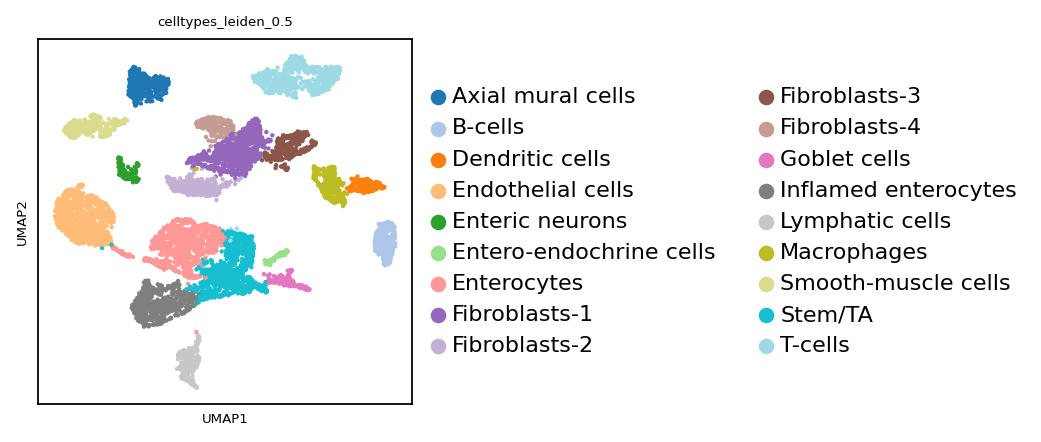

In [4]:
sc.pl.umap(ileum_infection_sc, color = ['celltypes_leiden_0.5'], legend_fontsize=10)

In [9]:
# This creates a new meta data varibale condition_new where all mocks have been merged into one sample

ileum_infection_sc.obs["condition_new"] = ileum_infection_sc.obs["condition"].map({"Mock_D1PI": "Mock", "Mock_D4PI": "Mock", "T1L-WT_D1PI": "T1L-WT_D1PI", "T1L-WT_D4PI": "T1L-WT_D4PI"}).astype("category")
ileum_infection_sc.obs["condition_new"].cat.reorder_categories(new_categories=["Mock", "T1L-WT_D1PI", "T1L-WT_D4PI"], inplace = True)

In [10]:
sc.tl.rank_genes_groups(ileum_infection_sc, groupby = 'condition_new', groups= ["T1L-WT_D1PI"],
                        reference= 'Mock', key_added='rank_genes_T1L-WT_vs_Mock-merged_D1PI',
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_T1L-WT_vs_Mock-merged_D1PI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


In [11]:
day1_WT_infection_markers = sc.get.rank_genes_groups_df(ileum_infection_sc, group="T1L-WT_D1PI", key="rank_genes_T1L-WT_vs_Mock-merged_D1PI")
# Genes with greater than 10 foldchange were sec specific genes on X chromosome like Xist, Tsix, etc
day1_WT_infection_markers = day1_WT_infection_markers[day1_WT_infection_markers["logfoldchanges"] < 10]
# day1_WT_infection_markers.to_csv("./ileum_IFN_genelist_D1PI.csv")
day1_WT_infection_markers_significant = day1_WT_infection_markers[day1_WT_infection_markers["logfoldchanges"] > 1.0]
day1_WT_infection_markers_significant = day1_WT_infection_markers_significant[day1_WT_infection_markers_significant["pvals_adj"] < 0.01]
day1_WT_infection_markers_significant = day1_WT_infection_markers_significant.sort_values(by= "scores", ascending=False)
print(day1_WT_infection_markers_significant)

        names     scores  logfoldchanges          pvals      pvals_adj
1       Isg15  39.504635        4.914759   0.000000e+00   0.000000e+00
2        Bst2  38.091705        3.520500   0.000000e+00   0.000000e+00
3         B2m  35.982697        1.996466  1.560063e-283  7.433702e-280
4       Ifit3  31.174690        5.819851  2.347955e-213  8.950406e-210
5        Irf7  30.486860        3.807481  3.891747e-204  1.236278e-200
..        ...        ...             ...            ...            ...
828    Rab3ip   3.302477        1.308228   9.583487e-04   8.257742e-03
830  B4galnt1   3.299157        2.014594   9.697551e-04   8.325916e-03
831   Gm47242   3.295209        6.060138   9.834849e-04   8.432398e-03
838    H2-Eb1   3.259612        1.016864   1.115648e-03   9.434006e-03
839       Mbp   3.251768        1.462784   1.146895e-03   9.689637e-03

[438 rows x 5 columns]


In [12]:
# Preparing genes from DGEA for infection response analysis  
de_results = day1_WT_infection_markers_significant
de_results = de_results[(de_results["logfoldchanges"] > 1.0) & (de_results["pvals_adj"] < 0.01)]
glist = de_results['names'].squeeze().str.strip().tolist()

In [13]:
# GO_Biological_Process_2021, 
enr_res = gseapy.enrichr(gene_list=glist, 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway', 
                     cutoff = 0.01)

Connecting to Enrichr Server to get latest library names
Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:3915d0d3300d2398f15898a820a3e173
Done.



In [14]:
enr_res.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular response to type I interferon (GO:007...,24/65,1.376040e-23,1.452410e-20,0,0,27.601273,1452.937812,SP100;RSAD2;STAT1;MX2;STAT2;MX1;ADAR;ISG15;IFI...
1,GO_Biological_Process_2021,type I interferon signaling pathway (GO:0060337),24/65,1.376040e-23,1.452410e-20,0,0,27.601273,1452.937812,SP100;RSAD2;STAT1;MX2;STAT2;MX1;ADAR;ISG15;IFI...
2,GO_Biological_Process_2021,defense response to virus (GO:0051607),27/133,9.917758e-19,6.978795e-16,0,0,12.057843,499.855360,RTP4;NLRC5;IFIT1;SAMHD1;IFIT3;IFIT2;PYCARD;IFI...
3,GO_Biological_Process_2021,defense response to symbiont (GO:0140546),25/124,2.329539e-17,1.229414e-14,0,0,11.900482,455.767939,RTP4;NLRC5;IFIT1;SAMHD1;IFIT3;IFIT2;PYCARD;IFI...
4,GO_Biological_Process_2021,negative regulation of viral process (GO:0048525),19/70,4.538640e-16,1.916214e-13,0,0,17.347981,612.882199,RSAD2;STAT1;MX1;EIF2AK2;ISG15;ZC3HAV1;IFIT1;PM...
...,...,...,...,...,...,...,...,...,...,...
2106,GO_Biological_Process_2021,"regulation of transcription, DNA-templated (GO...",33/2244,9.962307e-01,9.976930e-01,0,0,0.639432,0.002415,EHF;CDKN1A;SP100;HSPD1;CDH1;MYC;HNF4A;CD74;DAX...
2107,GO_Biological_Process_2021,"RNA splicing, via transesterification reaction...",1/251,9.962751e-01,9.976930e-01,0,0,0.176769,0.000660,PRPF38A
2108,GO_Biological_Process_2021,inorganic cation transmembrane transport (GO:0...,1/274,9.977758e-01,9.982486e-01,0,0,0.161683,0.000360,ATP1B1
2109,GO_Biological_Process_2021,"mRNA splicing, via spliceosome (GO:0000398)",1/274,9.977758e-01,9.982486e-01,0,0,0.161683,0.000360,PRPF38A


(2111, 11)


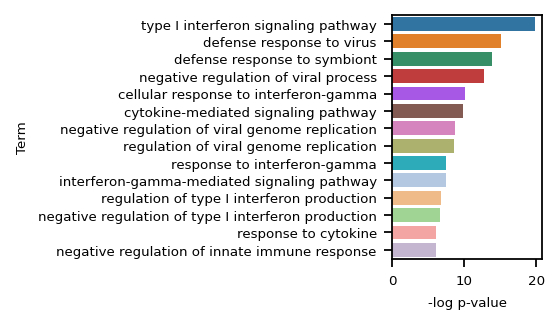

In [16]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
print(GO_results.shape)

sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,2.0))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[1:15], ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
# plt.tight_layout()
plt.show()

In [17]:
gene_list = list(list(day1_WT_infection_markers_significant["names"][1:30]))
print(gene_list)

['Bst2', 'B2m', 'Ifit3', 'Irf7', 'Ifit1', 'Ifit2', 'Psmb8', 'Rsad2', 'H2-K1', 'H2-D1', 'Ly6e', 'Plac8', 'Iigp1', 'Rnf213', 'Oasl2', 'Cmpk2', 'Trim30a', 'Stat1', 'Slfn2', 'Ifi44', 'Usp18', 'Irgm1', 'H2-T23', 'Xaf1', 'Igtp', 'Ifi35', 'Lypd8', 'Rtp4', 'Oasl1']


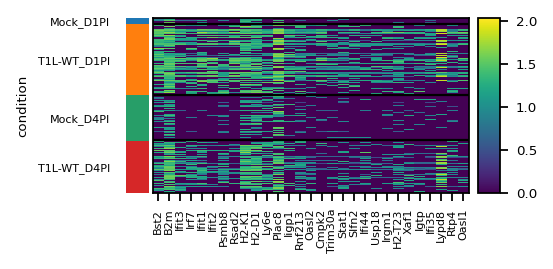

In [19]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, vector_friendly = False, transparent=True, format="pdf")
sc.pl.heatmap(ileum_infection_sc, var_names = gene_list, groupby="condition", log=True, show_gene_labels=True, figsize=(3.0,1.5))
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

In [20]:
sc.tl.score_genes(ileum_infection_sc, day1_WT_infection_markers_significant["names"], use_raw=True, score_name = 'Infection_response_score')

computing score 'Infection_response_score'
    finished: added
    'Infection_response_score', score of gene set (adata.obs).
    664 total control genes are used. (0:00:00)


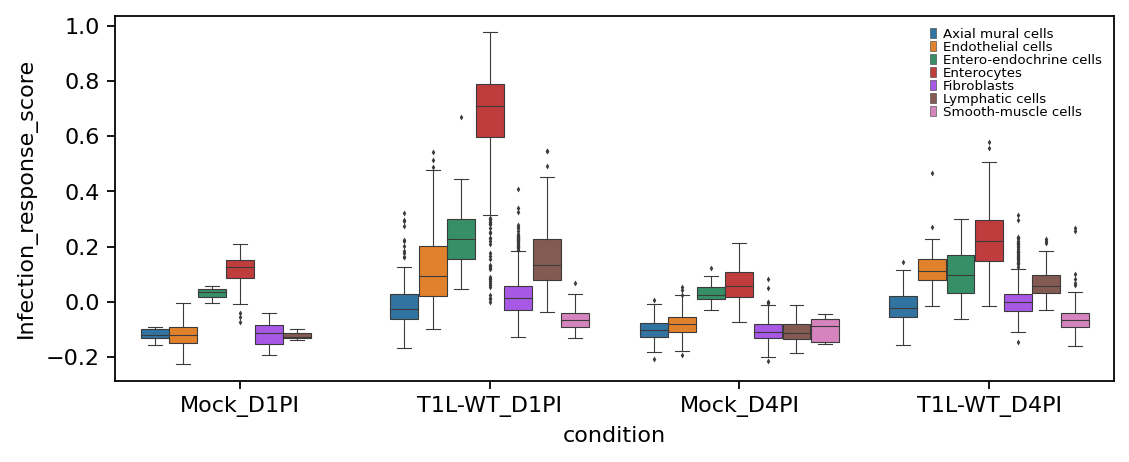

In [21]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=10, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(8, 3))
plt.rc('font', size=6)
plt.grid(b=None)
ax.set_axisbelow(True)
sns.boxplot(data = ileum_infection_sc[ileum_infection_sc.obs['celltype_groups'].isin(["Enterocytes", "Entero-endochrine cells", "Fibroblasts", "Smooth-muscle cells", "Axial mural cells", "Endothelial cells", "Lymphatic cells", ])].obs, y= "Infection_response_score", x = "condition", linewidth = 0.5, fliersize = 0.5, hue = "celltype_groups", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
ax.legend(loc = "best")
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.0)
# plt.tight_layout()
plt.show()

In [22]:
counts = ileum_infection_sc.obs.value_counts(subset=["state", "stage", "celltypes_leiden_0.5"]).unstack()
counts = counts.div(counts.sum(axis=1), axis=0)
counts = pd.DataFrame(counts.stack().astype("float"), columns=["Proportions"])
counts = counts.join(counts.index.to_frame())
counts.index = [i for i in range(counts.shape[0])]
# counts["celltypes_leiden_0.5"] = counts["celltypes_leiden_0.5"].astype("string")

In [23]:
counts["Condition"] = counts.apply(lambda x:'%s-%s' % (x['state'],x['stage']),axis=1)
counts

,Proportions,state,stage,celltypes_leiden_0.5,Condition
0,0.029630,Mock,D1PI,Axial mural cells,Mock-D1PI
1,0.003704,Mock,D1PI,Dendritic cells,Mock-D1PI
2,0.403704,Mock,D1PI,Endothelial cells,Mock-D1PI
3,0.011111,Mock,D1PI,Enteric neurons,Mock-D1PI
4,0.011111,Mock,D1PI,Entero-endochrine cells,Mock-D1PI
...,...,...,...,...,...
61,0.042119,T1L-WT,D4PI,Lymphatic cells,T1L-WT-D4PI
62,0.057317,T1L-WT,D4PI,Macrophages,T1L-WT-D4PI
63,0.100738,T1L-WT,D4PI,Smooth-muscle cells,T1L-WT-D4PI
64,0.091620,T1L-WT,D4PI,Stem/TA,T1L-WT-D4PI


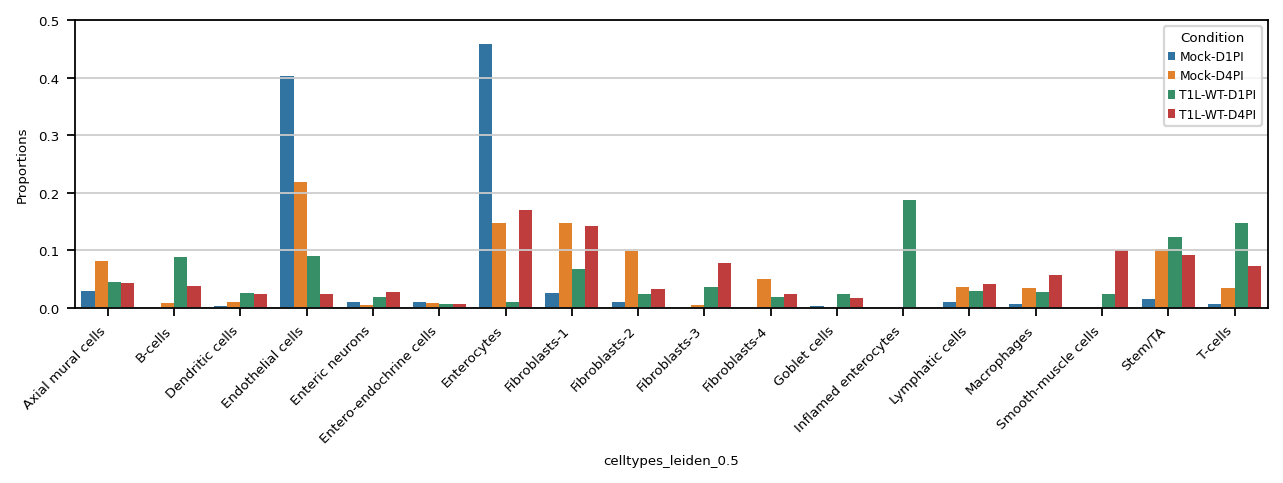

In [24]:
# & counts["celltypes_leiden_0.5"].isin(["Macrophages", "Dendritic cells", "B-cells", "T-cells", "NK cells", "Neutrophils"])
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, facecolor='white', frameon=True, transparent=True, format="pdf")
temp = counts[counts["state"].isin(["Mock", "T1L-WT"])] 
g, ax = plt.subplots(figsize=(8, 3))
plt.ylim((0,0.5))
g = sns.barplot(x = "celltypes_leiden_0.5", y = "Proportions", data= temp, hue = "Condition")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# g.set(ylim=(0, 1))
plt.tight_layout()
plt.show()

In [28]:
counts = ileum_infection_sc.obs.value_counts(subset=["state", "stage", "celltype_groups"]).unstack()
counts = counts.div(counts.sum(axis=1), axis=0)
counts = pd.DataFrame(counts.stack().astype("float"), columns=["Proportions"])
counts = counts.join(counts.index.to_frame())
counts.index = [i for i in range(counts.shape[0])]
counts["Condition"] = counts.apply(lambda x:'%s-%s' % (x['state'],x['stage']),axis=1)
counts

,Proportions,state,stage,celltype_groups,Condition
0,0.029630,Mock,D1PI,Axial mural cells,Mock-D1PI
1,0.003704,Mock,D1PI,Dendritic cells,Mock-D1PI
2,0.403704,Mock,D1PI,Endothelial cells,Mock-D1PI
3,0.011111,Mock,D1PI,Enteric neurons,Mock-D1PI
4,0.011111,Mock,D1PI,Entero-endochrine cells,Mock-D1PI
5,0.459259,Mock,D1PI,Enterocytes,Mock-D1PI
6,0.037037,Mock,D1PI,Fibroblasts,Mock-D1PI
7,0.003704,Mock,D1PI,Goblet cells,Mock-D1PI
8,0.011111,Mock,D1PI,Lymphatic cells,Mock-D1PI
9,0.007407,Mock,D1PI,Macrophages,Mock-D1PI


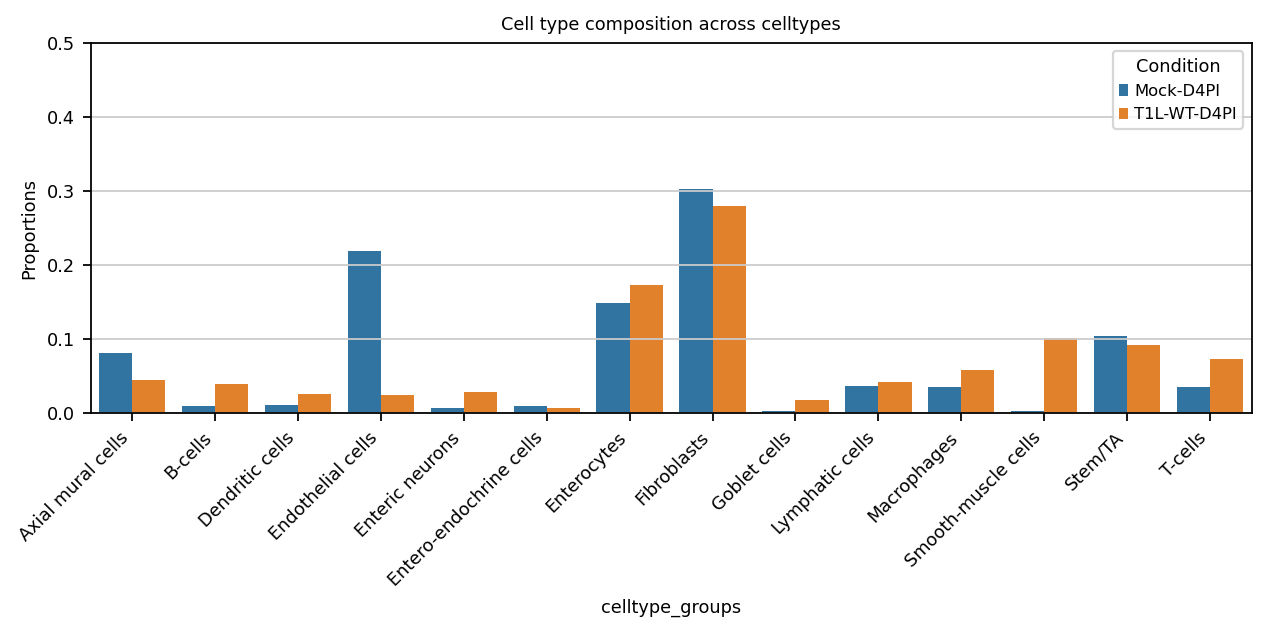

In [29]:
# & counts["celltypes_leiden_0.5"].isin(["Macrophages", "Dendritic cells", "B-cells", "T-cells", "NK cells", "Neutrophils"])
sc.settings.set_figure_params(dpi_save= 400, fontsize=8, facecolor='white', frameon=True, transparent=True, format="pdf")
temp = counts[counts["state"].isin(["Mock", "T1L-WT"]) & counts["stage"].isin(["D4PI"])] 
g, ax = plt.subplots(figsize=(8, 4))
plt.ylim((0,0.5))
g = sns.barplot(x = "celltype_groups", y = "Proportions", data= temp, hue = "Condition").set(title = "Cell type composition across celltypes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# g.set(ylim=(0, 1))
plt.tight_layout()
plt.show()

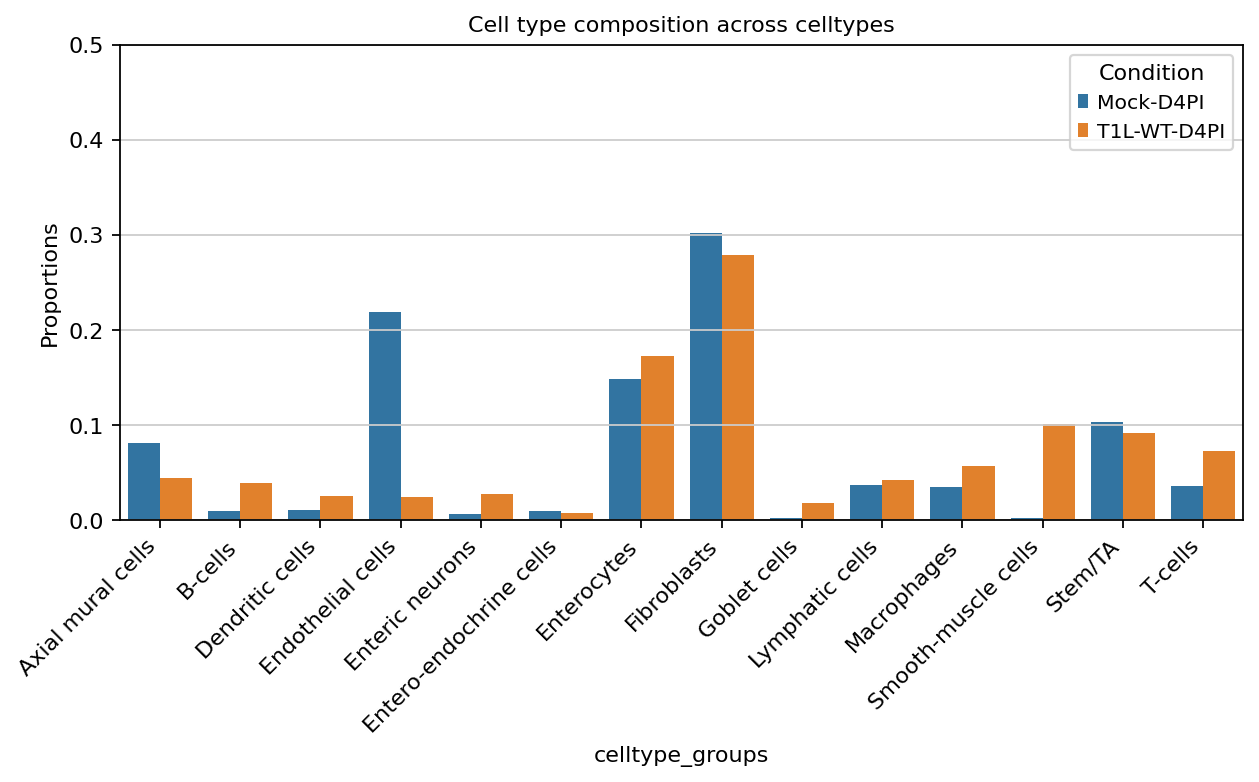

In [30]:
# & counts["celltypes_leiden_0.5"].isin(["Macrophages", "Dendritic cells", "B-cells", "T-cells", "NK cells", "Neutrophils"])
sc.settings.set_figure_params(dpi_save= 400, fontsize=10, facecolor='white', frameon=True, transparent=True, format="pdf")
temp = counts[counts["state"].isin(["Mock", "T1L-WT"]) & counts["stage"].isin(["D4PI"])] 
g, ax = plt.subplots(figsize=(8, 5))
plt.ylim((0,0.5))
g = sns.barplot(x = "celltype_groups", y = "Proportions", data= temp, hue = "Condition").set(title = "Cell type composition across celltypes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# g.set(ylim=(0, 1))
plt.tight_layout()
plt.show()